In [1]:
import logging
import torch
from datetime import datetime
logging.basicConfig(level=logging.INFO)
from torch_geometric.data import Dataset, DataLoader
from torch_geometric.data import Data
logging.info(f"{torch.cuda.is_available()}, {torch.cuda.get_device_name(0)}")
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')
from layers import GCNLayer,RNNEncoder, AttentionDecoderCell, output_layer
from torch_geometric.nn import global_add_pool as gap, global_max_pool as gmp

In [2]:
import torch.profiler as profiler

In [3]:
import torch.nn.functional as F

In [4]:
TIME_SLICE_NAME = 'exemplarid'
root_dir = '/blue/ranka/yashaswikarnati/yash_simulation_data/datagen_multilane/train_data_moe_pdf_one_dir'

In [5]:
from dataloader_pth_files import MOEPDFDataset

In [6]:
dataset =  MOEPDFDataset(root_dir=root_dir, start_index =0, end_index = 260000,set_str= 'train')

logging.info(f"******** data loaded ****** {dataset.len()}" )

dataloader_kwargs = {'batch_size' : 1500, 'shuffle' : True, 'num_workers':5}
data_loader = DataLoader(dataset,**dataloader_kwargs)

INFO:root:******** data loaded ****** 259891


In [7]:
sample_data = next(iter(data_loader))
local_batch = sample_data.to(device)

In [8]:
IDX_CHANNEL = 1
IDX_SPATIAL = 0
IDX_TEMPORAL = 2

In [9]:
class EncoderDecoderWrapper():
    def __init__(self, in_channels, out_channels, sequence_len,rnn_hid_size, output_size=3, teacher_forcing=0.3):
        super().__init__()
        
        self.gcn_layer = GCNLayer(in_channels, out_channels).to(device)
        self.encoder = RNNEncoder(rnn_num_layers=1, input_feature_len=(2*out_channels)+7,
                                  sequence_len=sequence_len, hidden_size=rnn_hid_size).to(device)
                                  
        self.decoder_cell = AttentionDecoderCell( hidden_size = rnn_hid_size, 
                                                 sequence_len = sequence_len).to(device)
        self.output_size = output_size
        self.teacher_forcing = teacher_forcing
        self.sequence_len = sequence_len
        
    def train(self):
        self.gcn_layer.train()
        self.encoder.train()
        self.decoder_cell.train()
        
    def eval(self):
        self.gcn_layer.eval()
        self.encoder.eval()
        self.decoder_cell.eval()
        
    def state_dict(self):
        return {
            'gcn_layer': self.gcn_layer.state_dict(),
            'encoder': self.encoder.state_dict(),
            'decoder_cell': self.decoder_cell.state_dict()
        }
    
    def load_state_dict(self, state_dict):
        self.gcn_layer.load_state_dict(state_dict['gcn_layer'])
        self.encoder.load_state_dict(state_dict['encoder'])
        self.decoder_cell.load_state_dict(state_dict['decoder_cell'])

    def __call__(self, data):
        gc_out = self.gcn_layer(data)
        concat_x = torch.cat([local_batch.x.reshape(-1,7,self.sequence_len),gc_out], dim=IDX_CHANNEL)
        yb = data.y
        input_seq = concat_x.transpose(1, 2)
#         logging.info(f"input seq. {input_seq.shape}")
        encoder_output, encoder_hidden = self.encoder(input_seq)
#         logging.info(f"encoder output {encoder_output.shape} hidden {encoder_hidden.shape}")
        
        prev_hidden = encoder_hidden
        if torch.cuda.is_available():
            outputs = torch.zeros(input_seq.size(0), self.output_size, device=device)
        else:
            outputs = torch.zeros(input_seq.size(0), self.output_size)
        y_prev = yb[:,0].unsqueeze(1)
        
        outputs[:, 0] = yb[:,0]
        for i in range(1,self.output_size):
            if (yb is not None) and (i > 0) and (torch.rand(1) < self.teacher_forcing):
                y_prev = yb[:, i-1].unsqueeze(1)
#             logging.info(f"y_prev  {y_prev.shape}")
            rnn_output, prev_hidden = self.decoder_cell(encoder_output, prev_hidden, y_prev)
#             logging.info(f"rnn output {rnn_output.shape}")
#             logging.info(f"prev hidden {prev_hidden.shape}")
            y_prev = rnn_output
            outputs[:, i] = rnn_output.squeeze(1)
        return F.softmax(outputs, dim =1)

In [10]:
def custom_loss_hellinger(p,q):
    z  = torch.sqrt(p) - torch.sqrt(q)
    return torch.mean(torch.sqrt((torch.bmm(z.view(z.shape[0], 1, z.shape[1]), z.view(z.shape[0], z.shape[1], 1)).squeeze(-1))/2))

In [11]:
criterion = torch.nn.MSELoss()

In [12]:
gc_edtam = EncoderDecoderWrapper(in_channels = 1, out_channels = 20, sequence_len = 72,rnn_hid_size = 50, output_size=200, teacher_forcing=0.3)

In [13]:
gcn_layer = gc_edtam.gcn_layer.to(device)
gc_optimizer = torch.optim.Adam(gcn_layer.parameters(), lr=0.001)

encoder = gc_edtam.encoder.to(device)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
decoder = gc_edtam.decoder_cell.to(device)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)

In [14]:
# gc_edtam.load_state_dict(torch.load('pthfiles/stgcn_pdf_hell_batch_45_epoch_0.pth'))

In [18]:
with torch.profiler.profile(
    activities = [torch.profiler.ProfilerActivity.CPU,
                 torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(
        wait=1,
        warmup=1,
        active=2),
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./result'),
    record_shapes = True
) as profiler:
    for i in range(5):
        rand_out = gc_edtam(local_batch)
        profiler.step()

In [22]:
print(profiler.key_averages().table(sort_by="cpu_time_total"))

In [16]:
with profiler.profile(record_shapes= True) as prof:
    with profiler.record_function("model_inference_gcedtam"):
        rand_out = gc_edtam(local_batch)

In [17]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                model_inference_gcedtam         6.17%     176.131ms       100.00%        2.857s        2.857s       0.000us         0.00%      73.703ms      73.703ms             1  
                                       cudaLaunchKernel        69.67%        1.990s        69.67%        1.990s     151.032us       0.000us         0.00%       0.000us       0.000us         13178  
         

In [23]:
profiler.export_chrome_trace("trace_gcedtam1.json")

In [13]:
gc_edtam.train()
for epoch in range(1,100):
    print ('Epoch {} at {}'.format(epoch, datetime.now().isoformat()))
    for k_batch, local_batch in enumerate(data_loader):
        gc_optimizer.zero_grad()
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        local_batch = local_batch.to(device)
        if( torch.isnan(local_batch.y).any()):
            logging.info(f" ****  nan found in y ****")
        out = gc_edtam(local_batch).squeeze(1)
#         out = torch.softmax(out,dim =1)
        loss = criterion(out, local_batch.y)
        loss.backward()
        logging.info('...with loss {} at {}'.format(loss.item(), datetime.now().isoformat()))
        gc_optimizer.step()
        encoder_optimizer.step()
        decoder_optimizer.step()
        if(k_batch%15 == 0):
            DICT_SAVE = gc_edtam.state_dict()
            torch.save(gc_edtam.state_dict(), f'pthfiles/gc-edtam_pdf_mse_batch_{k_batch}_epoch_{epoch}.pth')

Epoch 1 at 2021-04-11T15:30:31.828721


INFO:root:...with loss 0.0009233895689249039 at 2021-04-11T15:30:47.052083
INFO:root:...with loss 0.000890865980181843 at 2021-04-11T15:30:53.937921
INFO:root:...with loss 0.0008898524683900177 at 2021-04-11T15:31:01.893895
INFO:root:...with loss 0.0009216727921739221 at 2021-04-11T15:31:06.703154
INFO:root:...with loss 0.00089601194486022 at 2021-04-11T15:31:11.432940
INFO:root:...with loss 0.0008822912350296974 at 2021-04-11T15:31:16.768281
INFO:root:...with loss 0.0008673421107232571 at 2021-04-11T15:31:22.969376
INFO:root:...with loss 0.0008761604549363256 at 2021-04-11T15:31:26.325966
INFO:root:...with loss 0.0008494958747178316 at 2021-04-11T15:31:28.473486
INFO:root:...with loss 0.0008440032252110541 at 2021-04-11T15:31:30.683651
INFO:root:...with loss 0.0008375347242690623 at 2021-04-11T15:31:37.211337
INFO:root:...with loss 0.0008125059539452195 at 2021-04-11T15:31:40.010660
INFO:root:...with loss 0.0007970063015818596 at 2021-04-11T15:31:54.035931
INFO:root:...with loss 0.000

Epoch 2 at 2021-04-11T16:09:03.847444


INFO:root:...with loss 0.00017928291345015168 at 2021-04-11T16:09:16.419306
INFO:root:...with loss 0.00016786532069090754 at 2021-04-11T16:09:19.655401
INFO:root:...with loss 0.0001762984466040507 at 2021-04-11T16:09:24.953021
INFO:root:...with loss 0.00017465911514591426 at 2021-04-11T16:09:29.311515
INFO:root:...with loss 0.00018412632925901562 at 2021-04-11T16:09:53.082813
INFO:root:...with loss 0.00017167834448628128 at 2021-04-11T16:10:05.571538
INFO:root:...with loss 0.00016880226030480117 at 2021-04-11T16:10:13.778894
INFO:root:...with loss 0.0001761481980793178 at 2021-04-11T16:10:28.166269
INFO:root:...with loss 0.00017433844914194196 at 2021-04-11T16:10:32.515852
INFO:root:...with loss 0.00017056803335435688 at 2021-04-11T16:10:53.581839
INFO:root:...with loss 0.00017780339112505317 at 2021-04-11T16:10:56.778612
INFO:root:...with loss 0.0001746938214637339 at 2021-04-11T16:11:17.516657
INFO:root:...with loss 0.00017607258632779121 at 2021-04-11T16:11:22.868383
INFO:root:...wi

Epoch 3 at 2021-04-11T17:27:32.703837


INFO:root:...with loss 0.00015497316780965775 at 2021-04-11T17:27:56.480772
INFO:root:...with loss 0.00016361182497348636 at 2021-04-11T17:29:53.156912
INFO:root:...with loss 0.00016657021478749812 at 2021-04-11T17:31:56.472918
INFO:root:...with loss 0.00015416592941619456 at 2021-04-11T17:33:20.547046
INFO:root:...with loss 0.00015993966371752322 at 2021-04-11T17:34:21.658621
INFO:root:...with loss 0.00015087438805494457 at 2021-04-11T17:36:49.665662
INFO:root:...with loss 0.00015223113587126136 at 2021-04-11T17:39:07.829221
INFO:root:...with loss 0.00015035983233246952 at 2021-04-11T17:39:17.712707
INFO:root:...with loss 0.00015574223652947694 at 2021-04-11T17:41:57.958243
INFO:root:...with loss 0.00014835616457276046 at 2021-04-11T17:44:44.501257
INFO:root:...with loss 0.00015334892668761313 at 2021-04-11T17:44:57.774693
INFO:root:...with loss 0.00015335206990130246 at 2021-04-11T17:45:20.118244
INFO:root:...with loss 0.00015286817506421357 at 2021-04-11T17:45:32.816826
INFO:root:..

Epoch 4 at 2021-04-11T18:33:04.650643


INFO:root:...with loss 0.00014311772247310728 at 2021-04-11T18:33:11.716328
INFO:root:...with loss 0.00014929816825315356 at 2021-04-11T18:33:18.241422
INFO:root:...with loss 0.0001434888254152611 at 2021-04-11T18:33:21.819366
INFO:root:...with loss 0.00014080980326980352 at 2021-04-11T18:33:31.271201
INFO:root:...with loss 0.00014412649034056813 at 2021-04-11T18:33:38.644792
INFO:root:...with loss 0.00015008020272944123 at 2021-04-11T18:33:44.384449
INFO:root:...with loss 0.00014372443547472358 at 2021-04-11T18:33:55.091576
INFO:root:...with loss 0.00015052214439492673 at 2021-04-11T18:33:59.056267
INFO:root:...with loss 0.00013746049080509692 at 2021-04-11T18:34:08.909666
INFO:root:...with loss 0.00014799517521169037 at 2021-04-11T18:34:17.555334
INFO:root:...with loss 0.0001395715371472761 at 2021-04-11T18:34:30.106681
INFO:root:...with loss 0.00013443421630654484 at 2021-04-11T18:34:33.890914
INFO:root:...with loss 0.0001388255914207548 at 2021-04-11T18:34:41.652874
INFO:root:...wi

Epoch 5 at 2021-04-11T19:00:22.112227


INFO:root:...with loss 0.000142949415021576 at 2021-04-11T19:00:28.214820
INFO:root:...with loss 0.00014484336134046316 at 2021-04-11T19:00:39.474695
INFO:root:...with loss 0.00013053703878540546 at 2021-04-11T19:00:45.355759
INFO:root:...with loss 0.00013511527504306287 at 2021-04-11T19:00:51.816980
INFO:root:...with loss 0.0001311346422880888 at 2021-04-11T19:01:10.917808
INFO:root:...with loss 0.00013610692985821515 at 2021-04-11T19:01:16.140595
INFO:root:...with loss 0.00013541424414142966 at 2021-04-11T19:01:24.111375
INFO:root:...with loss 0.00012877942936029285 at 2021-04-11T19:01:30.829997
INFO:root:...with loss 0.00013456378655973822 at 2021-04-11T19:01:43.883315
INFO:root:...with loss 0.00013733070227317512 at 2021-04-11T19:01:48.985926
INFO:root:...with loss 0.00013277024845592678 at 2021-04-11T19:02:09.594133
INFO:root:...with loss 0.00013695700909011066 at 2021-04-11T19:02:14.404626
INFO:root:...with loss 0.0001318700087722391 at 2021-04-11T19:02:22.029569
INFO:root:...wit

Epoch 6 at 2021-04-11T19:41:15.060389


INFO:root:...with loss 0.0001408871466992423 at 2021-04-11T19:41:19.142199
INFO:root:...with loss 0.00013559569197241217 at 2021-04-11T19:41:22.985519
INFO:root:...with loss 0.00012737482029478997 at 2021-04-11T19:41:29.597681
INFO:root:...with loss 0.00012605293886736035 at 2021-04-11T19:41:35.958653
INFO:root:...with loss 0.00013337278505787253 at 2021-04-11T19:41:39.330554
INFO:root:...with loss 0.0001323043688898906 at 2021-04-11T19:41:42.291984
INFO:root:...with loss 0.0001288687635678798 at 2021-04-11T19:41:46.356404
INFO:root:...with loss 0.00013289909111335874 at 2021-04-11T19:41:50.799292
INFO:root:...with loss 0.00013417027366813272 at 2021-04-11T19:41:56.720093
INFO:root:...with loss 0.000124706668430008 at 2021-04-11T19:42:00.839553
INFO:root:...with loss 0.0001371880789520219 at 2021-04-11T19:42:04.241131
INFO:root:...with loss 0.0001299710856983438 at 2021-04-11T19:42:08.156408
INFO:root:...with loss 0.00012762489495798945 at 2021-04-11T19:42:12.015114
INFO:root:...with l

Epoch 7 at 2021-04-11T20:09:22.872281


INFO:root:...with loss 0.00012463015445973724 at 2021-04-11T20:09:26.115928
INFO:root:...with loss 0.00012695086479652673 at 2021-04-11T20:09:29.471885
INFO:root:...with loss 0.00012376060476526618 at 2021-04-11T20:09:32.698713
INFO:root:...with loss 0.0001275257091037929 at 2021-04-11T20:09:36.150622
INFO:root:...with loss 0.00012573252024594694 at 2021-04-11T20:09:42.337340
INFO:root:...with loss 0.00012348928430583328 at 2021-04-11T20:09:45.622897
INFO:root:...with loss 0.0001370229438180104 at 2021-04-11T20:09:48.777996
INFO:root:...with loss 0.0001224424922838807 at 2021-04-11T20:09:52.214787
INFO:root:...with loss 0.00013513474550563842 at 2021-04-11T20:09:55.630835
INFO:root:...with loss 0.00011915322829736397 at 2021-04-11T20:09:59.287580
INFO:root:...with loss 0.0001324806798947975 at 2021-04-11T20:10:07.189835
INFO:root:...with loss 0.00012958538718521595 at 2021-04-11T20:10:12.352773
INFO:root:...with loss 0.00012850009079556912 at 2021-04-11T20:10:15.707282
INFO:root:...wit

Epoch 8 at 2021-04-11T20:23:02.875716


INFO:root:...with loss 0.00012857541150879115 at 2021-04-11T20:23:21.086184
INFO:root:...with loss 0.00012831193453166634 at 2021-04-11T20:23:30.929897
INFO:root:...with loss 0.00012895862164441496 at 2021-04-11T20:23:49.558490
INFO:root:...with loss 0.00012383286957629025 at 2021-04-11T20:24:06.275173
INFO:root:...with loss 0.00013219326501712203 at 2021-04-11T20:24:13.082836
INFO:root:...with loss 0.00012482165766414255 at 2021-04-11T20:24:20.547410
INFO:root:...with loss 0.00012564151256810874 at 2021-04-11T20:24:27.073507
INFO:root:...with loss 0.00012412019714247435 at 2021-04-11T20:24:34.005567
INFO:root:...with loss 0.0001229398330906406 at 2021-04-11T20:24:40.402562
INFO:root:...with loss 0.00012597106979228556 at 2021-04-11T20:24:51.779200
INFO:root:...with loss 0.00012269284343346953 at 2021-04-11T20:25:02.074487
INFO:root:...with loss 0.00011784825619542971 at 2021-04-11T20:26:12.460997
INFO:root:...with loss 0.00012575213622767478 at 2021-04-11T20:26:27.313989
INFO:root:...

Epoch 9 at 2021-04-11T20:55:48.226694


INFO:root:...with loss 0.00012538164446596056 at 2021-04-11T20:55:52.938928
INFO:root:...with loss 0.00012111844262108207 at 2021-04-11T20:55:56.473391
INFO:root:...with loss 0.00012204940867377445 at 2021-04-11T20:55:59.659432
INFO:root:...with loss 0.00013407257210928947 at 2021-04-11T20:56:03.924621
INFO:root:...with loss 0.00012321118265390396 at 2021-04-11T20:56:07.162157
INFO:root:...with loss 0.0001217220415128395 at 2021-04-11T20:56:10.692930
INFO:root:...with loss 0.00011895280476892367 at 2021-04-11T20:56:14.235281
INFO:root:...with loss 0.00012193484144518152 at 2021-04-11T20:56:17.488509
INFO:root:...with loss 0.00012363764108158648 at 2021-04-11T20:56:20.705268
INFO:root:...with loss 0.00012336907093413174 at 2021-04-11T20:56:23.954383
INFO:root:...with loss 0.00013407434744294733 at 2021-04-11T20:56:28.117479
INFO:root:...with loss 0.00014842096425127238 at 2021-04-11T20:56:31.914738
INFO:root:...with loss 0.00012471555965021253 at 2021-04-11T20:56:35.468776
INFO:root:...

Epoch 10 at 2021-04-11T21:07:21.246703


INFO:root:...with loss 0.00011971544881816953 at 2021-04-11T21:07:24.581273
INFO:root:...with loss 0.00012870658247265965 at 2021-04-11T21:07:27.741299
INFO:root:...with loss 0.00011082196579081938 at 2021-04-11T21:07:31.281741
INFO:root:...with loss 0.00012229353887960315 at 2021-04-11T21:07:34.928403
INFO:root:...with loss 0.00012275297194719315 at 2021-04-11T21:07:38.422113
INFO:root:...with loss 0.00011872694449266419 at 2021-04-11T21:07:44.347651
INFO:root:...with loss 0.0001280787109863013 at 2021-04-11T21:07:47.504303
INFO:root:...with loss 0.00011369984713383019 at 2021-04-11T21:07:51.813917
INFO:root:...with loss 0.00012000175775028765 at 2021-04-11T21:07:56.704454
INFO:root:...with loss 0.00011623509635683149 at 2021-04-11T21:08:02.227302
INFO:root:...with loss 0.00011575303506106138 at 2021-04-11T21:08:07.946229
INFO:root:...with loss 0.00011626169725786895 at 2021-04-11T21:08:11.100496
INFO:root:...with loss 0.00012130525283282623 at 2021-04-11T21:08:15.856811
INFO:root:...

Epoch 11 at 2021-04-11T21:32:50.809316


INFO:root:...with loss 0.0001195697404909879 at 2021-04-11T21:32:54.577616
INFO:root:...with loss 0.0001230273919645697 at 2021-04-11T21:32:58.474205
INFO:root:...with loss 0.00011559178528841585 at 2021-04-11T21:33:01.625622
INFO:root:...with loss 0.00011489246389828622 at 2021-04-11T21:33:05.942662
INFO:root:...with loss 0.00011623321188380942 at 2021-04-11T21:33:09.368672
INFO:root:...with loss 0.0001199091348098591 at 2021-04-11T21:33:12.804857
INFO:root:...with loss 0.00011353068111930043 at 2021-04-11T21:33:16.433699
INFO:root:...with loss 0.00011875073687406257 at 2021-04-11T21:33:19.740481
INFO:root:...with loss 0.00011434448242653161 at 2021-04-11T21:33:22.788093
INFO:root:...with loss 0.00011411144078010693 at 2021-04-11T21:33:26.175046
INFO:root:...with loss 0.00011329277185723186 at 2021-04-11T21:33:29.571083
INFO:root:...with loss 0.00011398919741623104 at 2021-04-11T21:33:32.773675
INFO:root:...with loss 0.00011267954687355086 at 2021-04-11T21:33:37.503482
INFO:root:...wi

Epoch 12 at 2021-04-11T21:44:32.307161


INFO:root:...with loss 0.00011108918261015788 at 2021-04-11T21:44:35.584811
INFO:root:...with loss 0.00011213641846552491 at 2021-04-11T21:44:38.787692
INFO:root:...with loss 0.00011351860302966088 at 2021-04-11T21:44:41.958855
INFO:root:...with loss 0.00011079468094976619 at 2021-04-11T21:44:44.833766
INFO:root:...with loss 0.0001049377242452465 at 2021-04-11T21:44:47.928304
INFO:root:...with loss 0.00011575590906431898 at 2021-04-11T21:44:51.264579
INFO:root:...with loss 0.00012151400005677715 at 2021-04-11T21:44:54.435862
INFO:root:...with loss 0.00011036810610676184 at 2021-04-11T21:44:58.681569
INFO:root:...with loss 0.00011349166743457317 at 2021-04-11T21:45:01.797945
INFO:root:...with loss 0.00011946512677241117 at 2021-04-11T21:45:05.923268
INFO:root:...with loss 0.00011950242333114147 at 2021-04-11T21:45:09.053408
INFO:root:...with loss 0.00010949496208922938 at 2021-04-11T21:45:12.280694
INFO:root:...with loss 0.0001028083570417948 at 2021-04-11T21:45:15.527793
INFO:root:...w

Epoch 13 at 2021-04-11T22:05:27.195962


INFO:root:...with loss 0.00012567029625643045 at 2021-04-11T22:05:31.122425
INFO:root:...with loss 0.00011648090003291145 at 2021-04-11T22:05:34.603922
INFO:root:...with loss 0.00011443777475506067 at 2021-04-11T22:05:38.244791
INFO:root:...with loss 0.00011232480028411373 at 2021-04-11T22:05:41.320344
INFO:root:...with loss 0.00011738525063265115 at 2021-04-11T22:05:44.972918
INFO:root:...with loss 0.00011543696018634364 at 2021-04-11T22:05:47.939781
INFO:root:...with loss 0.00012070555385435 at 2021-04-11T22:05:51.636452
INFO:root:...with loss 0.00010665522131603211 at 2021-04-11T22:05:54.670325
INFO:root:...with loss 0.00011381342483218759 at 2021-04-11T22:05:57.859341
INFO:root:...with loss 0.00011661646567517892 at 2021-04-11T22:06:01.618067
INFO:root:...with loss 0.0001277751725865528 at 2021-04-11T22:06:04.899396
INFO:root:...with loss 0.00010678550461307168 at 2021-04-11T22:06:07.985748
INFO:root:...with loss 0.00012037101987516508 at 2021-04-11T22:06:12.013743
INFO:root:...wit

Epoch 14 at 2021-04-11T22:13:40.692601


INFO:root:...with loss 0.00011177021951880306 at 2021-04-11T22:13:43.053635
INFO:root:...with loss 0.0001097084823413752 at 2021-04-11T22:13:45.334426
INFO:root:...with loss 0.00010874427971430123 at 2021-04-11T22:13:47.885330
INFO:root:...with loss 0.00010514447058085352 at 2021-04-11T22:13:50.184521
INFO:root:...with loss 0.0001140130334533751 at 2021-04-11T22:13:52.645861
INFO:root:...with loss 0.00010829783423105255 at 2021-04-11T22:13:55.058213
INFO:root:...with loss 0.00010876922897296026 at 2021-04-11T22:13:57.462178
INFO:root:...with loss 0.00011263602209510282 at 2021-04-11T22:13:59.727126
INFO:root:...with loss 0.00011249152885284275 at 2021-04-11T22:14:01.999758
INFO:root:...with loss 0.00010590805322863162 at 2021-04-11T22:14:04.286271
INFO:root:...with loss 0.0001043776428559795 at 2021-04-11T22:14:06.553070
INFO:root:...with loss 0.00012163495557615533 at 2021-04-11T22:14:09.244580
INFO:root:...with loss 0.00010647547605913132 at 2021-04-11T22:14:11.658851
INFO:root:...wi

Epoch 15 at 2021-04-11T22:24:23.705406


INFO:root:...with loss 0.00011640160664683208 at 2021-04-11T22:24:26.870860
INFO:root:...with loss 0.00010434954310767353 at 2021-04-11T22:24:29.988671
INFO:root:...with loss 0.00010576852218946442 at 2021-04-11T22:24:33.261804
INFO:root:...with loss 0.00011893023474840447 at 2021-04-11T22:24:36.483829
INFO:root:...with loss 0.00011329610424581915 at 2021-04-11T22:24:39.856758
INFO:root:...with loss 0.00011104103032266721 at 2021-04-11T22:24:42.830363
INFO:root:...with loss 0.00011336233728798106 at 2021-04-11T22:24:45.964632
INFO:root:...with loss 0.00011119323607999831 at 2021-04-11T22:24:50.691662
INFO:root:...with loss 0.00011639287549769506 at 2021-04-11T22:24:57.262271
INFO:root:...with loss 0.0001070150756277144 at 2021-04-11T22:25:00.830554
INFO:root:...with loss 0.00010879476030822843 at 2021-04-11T22:25:08.492766
INFO:root:...with loss 0.0001092960883397609 at 2021-04-11T22:25:12.249253
INFO:root:...with loss 0.0001099281435017474 at 2021-04-11T22:25:15.292141
INFO:root:...wi

Epoch 16 at 2021-04-11T22:37:13.385920


INFO:root:...with loss 0.00010748750355560333 at 2021-04-11T22:37:17.102032
INFO:root:...with loss 0.00010513906454434618 at 2021-04-11T22:37:20.152312
INFO:root:...with loss 0.00011168248602189124 at 2021-04-11T22:37:23.088411
INFO:root:...with loss 0.00010445764928590506 at 2021-04-11T22:37:26.254003
INFO:root:...with loss 0.0001124349728343077 at 2021-04-11T22:37:29.149927
INFO:root:...with loss 0.00011005363194271922 at 2021-04-11T22:37:33.715186
INFO:root:...with loss 0.00011131334758829325 at 2021-04-11T22:37:36.567850
INFO:root:...with loss 0.00010758743155747652 at 2021-04-11T22:37:39.599102
INFO:root:...with loss 0.00010726149048423395 at 2021-04-11T22:37:42.876519
INFO:root:...with loss 0.00011063416604883969 at 2021-04-11T22:37:46.140028
INFO:root:...with loss 0.00011190947407158092 at 2021-04-11T22:37:49.312429
INFO:root:...with loss 0.00011187648487975821 at 2021-04-11T22:37:52.377807
INFO:root:...with loss 0.00010531187581364065 at 2021-04-11T22:37:55.439411
INFO:root:...

Epoch 17 at 2021-04-11T22:47:41.640346


INFO:root:...with loss 0.00010649002069840208 at 2021-04-11T22:47:45.609086
INFO:root:...with loss 0.00011633243411779404 at 2021-04-11T22:47:49.297463
INFO:root:...with loss 0.00010586674034129828 at 2021-04-11T22:47:52.966418
INFO:root:...with loss 0.00011782265937654302 at 2021-04-11T22:47:56.815883
INFO:root:...with loss 0.0001006699530989863 at 2021-04-11T22:48:00.738669
INFO:root:...with loss 0.00010730764915933833 at 2021-04-11T22:48:04.601025
INFO:root:...with loss 0.00010527028643991798 at 2021-04-11T22:48:07.702179
INFO:root:...with loss 0.00011433286272222176 at 2021-04-11T22:48:13.196810
INFO:root:...with loss 0.00011145886674057692 at 2021-04-11T22:48:16.183113
INFO:root:...with loss 0.00011295659351162612 at 2021-04-11T22:48:19.964834
INFO:root:...with loss 0.00011392543819965795 at 2021-04-11T22:48:26.299306
INFO:root:...with loss 0.00010591141472104937 at 2021-04-11T22:48:31.421285
INFO:root:...with loss 0.0001082198359654285 at 2021-04-11T22:48:41.332513
INFO:root:...w

Epoch 18 at 2021-04-11T22:59:32.716576


INFO:root:...with loss 0.00011001200618920848 at 2021-04-11T22:59:39.054349
INFO:root:...with loss 0.00011146779434056953 at 2021-04-11T22:59:42.700134
INFO:root:...with loss 0.00010949076386168599 at 2021-04-11T22:59:47.004736
INFO:root:...with loss 0.00010381814354332164 at 2021-04-11T23:00:27.314175
INFO:root:...with loss 0.0001049706552294083 at 2021-04-11T23:01:27.099527
INFO:root:...with loss 0.0001052777370205149 at 2021-04-11T23:02:19.542380
INFO:root:...with loss 0.0001085383992176503 at 2021-04-11T23:02:58.400464
INFO:root:...with loss 0.00010752502566901967 at 2021-04-11T23:04:00.988929
INFO:root:...with loss 0.00010626173752825707 at 2021-04-11T23:04:37.897819
INFO:root:...with loss 0.00010447519889567047 at 2021-04-11T23:04:41.248564
INFO:root:...with loss 0.00011333358997944742 at 2021-04-11T23:04:44.256643
INFO:root:...with loss 0.00010200304677709937 at 2021-04-11T23:04:47.181171
INFO:root:...with loss 0.00010930051212199032 at 2021-04-11T23:04:50.333410
INFO:root:...wi

Epoch 19 at 2021-04-11T23:22:59.424843


INFO:root:...with loss 0.00011316165910102427 at 2021-04-11T23:23:02.473513
INFO:root:...with loss 0.00011036376963602379 at 2021-04-11T23:23:05.565061
INFO:root:...with loss 0.0001047274490701966 at 2021-04-11T23:23:08.512250
INFO:root:...with loss 0.00011204521433683112 at 2021-04-11T23:23:11.570153
INFO:root:...with loss 0.00010541810479480773 at 2021-04-11T23:23:14.808630
INFO:root:...with loss 0.00010305867181159556 at 2021-04-11T23:23:18.062806
INFO:root:...with loss 0.00011457790242275223 at 2021-04-11T23:23:21.010886
INFO:root:...with loss 0.00010590541205601767 at 2021-04-11T23:23:24.078499
INFO:root:...with loss 0.00010911774006672204 at 2021-04-11T23:23:26.997839
INFO:root:...with loss 0.000115555951197166 at 2021-04-11T23:23:29.937123
INFO:root:...with loss 0.00011003221879946068 at 2021-04-11T23:23:33.147731
INFO:root:...with loss 0.00010648086754372343 at 2021-04-11T23:23:36.167629
INFO:root:...with loss 0.00010172318434342742 at 2021-04-11T23:23:39.360425
INFO:root:...wi

Epoch 20 at 2021-04-11T23:33:39.106573


INFO:root:...with loss 0.00010628397285472602 at 2021-04-11T23:33:42.087499
INFO:root:...with loss 0.00011663411714835092 at 2021-04-11T23:33:45.680760
INFO:root:...with loss 0.00010279293201165274 at 2021-04-11T23:33:54.764460
INFO:root:...with loss 0.00010580592788755894 at 2021-04-11T23:33:59.423060
INFO:root:...with loss 0.00010503940575290471 at 2021-04-11T23:34:22.679661
INFO:root:...with loss 0.00010576272325124592 at 2021-04-11T23:34:27.241585
INFO:root:...with loss 0.00010549478611210361 at 2021-04-11T23:34:30.118092
INFO:root:...with loss 0.0001063061281456612 at 2021-04-11T23:34:33.410819
INFO:root:...with loss 0.00010333712270949036 at 2021-04-11T23:34:36.926882
INFO:root:...with loss 0.00010767015919554979 at 2021-04-11T23:34:39.918899
INFO:root:...with loss 0.00010560263763181865 at 2021-04-11T23:34:42.844794
INFO:root:...with loss 0.00010804917837958783 at 2021-04-11T23:34:46.347466
INFO:root:...with loss 0.00010198717791354284 at 2021-04-11T23:34:49.393700
INFO:root:...

Epoch 21 at 2021-04-11T23:44:39.470136


INFO:root:...with loss 0.00010746836051112041 at 2021-04-11T23:44:42.584066
INFO:root:...with loss 0.00010789874067995697 at 2021-04-11T23:44:45.488715
INFO:root:...with loss 0.00010776308772619814 at 2021-04-11T23:44:48.434380
INFO:root:...with loss 0.00010870178084587678 at 2021-04-11T23:44:52.426133
INFO:root:...with loss 0.0001027245816658251 at 2021-04-11T23:44:55.444070
INFO:root:...with loss 0.000107077561551705 at 2021-04-11T23:44:58.426689
INFO:root:...with loss 0.0001067743287421763 at 2021-04-11T23:45:01.635381
INFO:root:...with loss 0.00010105458204634488 at 2021-04-11T23:45:06.185887
INFO:root:...with loss 0.00010530880535952747 at 2021-04-11T23:45:10.749396
INFO:root:...with loss 0.00010193805792368948 at 2021-04-11T23:45:15.175420
INFO:root:...with loss 0.00010451052366988733 at 2021-04-11T23:45:20.856379
INFO:root:...with loss 0.00011452221224317327 at 2021-04-11T23:45:24.956706
INFO:root:...with loss 0.00011061812256230041 at 2021-04-11T23:45:30.196163
INFO:root:...wit

Epoch 22 at 2021-04-12T00:04:16.545226


INFO:root:...with loss 0.0001074109022738412 at 2021-04-12T00:04:22.861663
INFO:root:...with loss 0.00011463066039141268 at 2021-04-12T00:04:26.571865
INFO:root:...with loss 0.00010927228140644729 at 2021-04-12T00:04:34.184857
INFO:root:...with loss 0.0001085003896150738 at 2021-04-12T00:04:45.933313
INFO:root:...with loss 0.00010197097435593605 at 2021-04-12T00:04:56.806713
INFO:root:...with loss 0.00011045805877074599 at 2021-04-12T00:05:02.717021
INFO:root:...with loss 0.0001038378759403713 at 2021-04-12T00:05:14.979455
INFO:root:...with loss 9.909873915603384e-05 at 2021-04-12T00:05:21.606017
INFO:root:...with loss 0.00010386601934442297 at 2021-04-12T00:05:26.439839
INFO:root:...with loss 9.515461715636775e-05 at 2021-04-12T00:05:30.657031
INFO:root:...with loss 0.00010722551814978942 at 2021-04-12T00:05:37.626417
INFO:root:...with loss 0.00010797701543197036 at 2021-04-12T00:05:45.722132
INFO:root:...with loss 9.989889804273844e-05 at 2021-04-12T00:05:54.048727
INFO:root:...with 

Epoch 23 at 2021-04-12T00:28:42.111471


INFO:root:...with loss 0.00010616646613925695 at 2021-04-12T00:28:48.320045
INFO:root:...with loss 0.00010072138684336096 at 2021-04-12T00:28:52.045174
INFO:root:...with loss 0.00010415745055070147 at 2021-04-12T00:29:10.250010
INFO:root:...with loss 0.0001055894244927913 at 2021-04-12T00:29:17.499382
INFO:root:...with loss 0.00010546921112108976 at 2021-04-12T00:29:23.376943
INFO:root:...with loss 0.0001116953935706988 at 2021-04-12T00:29:31.620076
INFO:root:...with loss 9.796166705200449e-05 at 2021-04-12T00:30:23.621678
INFO:root:...with loss 0.00010274845408275723 at 2021-04-12T00:30:27.998716
INFO:root:...with loss 0.00010405189823359251 at 2021-04-12T00:30:33.504032
INFO:root:...with loss 0.0001021563948597759 at 2021-04-12T00:30:39.067754
INFO:root:...with loss 0.00010104011016665027 at 2021-04-12T00:30:43.183235
INFO:root:...with loss 9.775621583685279e-05 at 2021-04-12T00:30:49.295459
INFO:root:...with loss 0.00010282301809638739 at 2021-04-12T00:30:52.464419
INFO:root:...with

Epoch 24 at 2021-04-12T00:42:17.488802


INFO:root:...with loss 9.9819058959838e-05 at 2021-04-12T00:42:20.698365
INFO:root:...with loss 0.00010765865590656176 at 2021-04-12T00:42:23.685388
INFO:root:...with loss 0.00010286972974427044 at 2021-04-12T00:42:27.266518
INFO:root:...with loss 9.226060501532629e-05 at 2021-04-12T00:42:31.052166
INFO:root:...with loss 9.970893734134734e-05 at 2021-04-12T00:42:35.760805
INFO:root:...with loss 9.913766552926973e-05 at 2021-04-12T00:42:39.381667
INFO:root:...with loss 0.00010394930723123252 at 2021-04-12T00:42:42.348541
INFO:root:...with loss 9.90682965493761e-05 at 2021-04-12T00:42:45.249376
INFO:root:...with loss 0.0001072390004992485 at 2021-04-12T00:42:48.292493
INFO:root:...with loss 0.00010595688945613801 at 2021-04-12T00:42:51.391121
INFO:root:...with loss 0.00010167144500883296 at 2021-04-12T00:42:54.519914
INFO:root:...with loss 9.985642827814445e-05 at 2021-04-12T00:42:57.653608
INFO:root:...with loss 9.556870645610616e-05 at 2021-04-12T00:43:01.315702
INFO:root:...with loss 

Epoch 25 at 2021-04-12T00:55:56.346946


INFO:root:...with loss 0.00010910272976616398 at 2021-04-12T00:55:59.317848
INFO:root:...with loss 0.00010560776718193665 at 2021-04-12T00:56:03.502271
INFO:root:...with loss 0.0001110453304136172 at 2021-04-12T00:56:06.729636
INFO:root:...with loss 0.00010199101234320551 at 2021-04-12T00:56:11.134910
INFO:root:...with loss 9.839610720518976e-05 at 2021-04-12T00:56:13.910487
INFO:root:...with loss 0.0001093051178031601 at 2021-04-12T00:56:17.821003
INFO:root:...with loss 0.00010567416757112369 at 2021-04-12T00:56:20.699599
INFO:root:...with loss 0.00010486361134098843 at 2021-04-12T00:56:25.580573
INFO:root:...with loss 0.00010200959513895214 at 2021-04-12T00:56:28.654534
INFO:root:...with loss 0.00010322437447030097 at 2021-04-12T00:56:32.788352
INFO:root:...with loss 9.915226110024378e-05 at 2021-04-12T00:56:37.307952
INFO:root:...with loss 0.00010389618546469137 at 2021-04-12T00:56:40.140712
INFO:root:...with loss 9.965749632101506e-05 at 2021-04-12T00:56:43.251955
INFO:root:...with

Epoch 26 at 2021-04-12T01:12:15.654538


INFO:root:...with loss 9.996785956900567e-05 at 2021-04-12T01:12:22.967927
INFO:root:...with loss 0.00010563986143097281 at 2021-04-12T01:12:25.976922
INFO:root:...with loss 9.86701634246856e-05 at 2021-04-12T01:12:29.055793
INFO:root:...with loss 9.393178333994001e-05 at 2021-04-12T01:12:32.368620
INFO:root:...with loss 9.944885823642835e-05 at 2021-04-12T01:12:35.429720
INFO:root:...with loss 9.56631192821078e-05 at 2021-04-12T01:12:38.721298
INFO:root:...with loss 9.457294800085947e-05 at 2021-04-12T01:12:42.843493
INFO:root:...with loss 0.00010268436744809151 at 2021-04-12T01:12:47.608350
INFO:root:...with loss 9.650536230765283e-05 at 2021-04-12T01:12:52.780165
INFO:root:...with loss 0.00010188577289227396 at 2021-04-12T01:12:56.461171
INFO:root:...with loss 0.00010118419595528394 at 2021-04-12T01:12:59.948767
INFO:root:...with loss 9.87908206298016e-05 at 2021-04-12T01:13:05.397088
INFO:root:...with loss 0.00010133144678547978 at 2021-04-12T01:13:09.326779
INFO:root:...with loss 

Epoch 27 at 2021-04-12T01:38:14.745930


INFO:root:...with loss 0.00010226616723230109 at 2021-04-12T01:38:17.636083
INFO:root:...with loss 0.0001089980942197144 at 2021-04-12T01:38:20.908229
INFO:root:...with loss 9.426508040633053e-05 at 2021-04-12T01:38:28.696267
INFO:root:...with loss 0.00011187248310307041 at 2021-04-12T01:38:32.482323
INFO:root:...with loss 9.764944115886465e-05 at 2021-04-12T01:38:35.463064
INFO:root:...with loss 0.00010208313324255869 at 2021-04-12T01:38:41.926035
INFO:root:...with loss 0.00010163848492084071 at 2021-04-12T01:38:45.795879
INFO:root:...with loss 9.827844041865319e-05 at 2021-04-12T01:38:48.857432
INFO:root:...with loss 9.71627450780943e-05 at 2021-04-12T01:38:51.535852
INFO:root:...with loss 9.920879529090598e-05 at 2021-04-12T01:38:56.695582
INFO:root:...with loss 9.350402979180217e-05 at 2021-04-12T01:39:00.136216
INFO:root:...with loss 0.00010443256178405136 at 2021-04-12T01:39:04.012675
INFO:root:...with loss 0.00010247011960018426 at 2021-04-12T01:39:07.042156
INFO:root:...with lo

Epoch 28 at 2021-04-12T01:49:13.497045


INFO:root:...with loss 9.848280751612037e-05 at 2021-04-12T01:49:16.699855
INFO:root:...with loss 0.00011766016541514546 at 2021-04-12T01:49:19.871013
INFO:root:...with loss 9.55548239289783e-05 at 2021-04-12T01:49:23.462587
INFO:root:...with loss 9.94201545836404e-05 at 2021-04-12T01:49:27.271133
INFO:root:...with loss 9.471477824263275e-05 at 2021-04-12T01:49:31.398818
INFO:root:...with loss 9.077371942112222e-05 at 2021-04-12T01:49:36.232119
INFO:root:...with loss 0.00010049362754216418 at 2021-04-12T01:49:39.697006
INFO:root:...with loss 0.00010060894419439137 at 2021-04-12T01:49:42.877205
INFO:root:...with loss 0.0001002483768388629 at 2021-04-12T01:49:45.697885
INFO:root:...with loss 9.513770055491477e-05 at 2021-04-12T01:49:49.141108
INFO:root:...with loss 9.614169539418072e-05 at 2021-04-12T01:49:52.458454
INFO:root:...with loss 9.949518425855786e-05 at 2021-04-12T01:49:55.546010
INFO:root:...with loss 0.00010152632603421807 at 2021-04-12T01:49:58.939296
INFO:root:...with loss 

Epoch 29 at 2021-04-12T02:05:18.027915


INFO:root:...with loss 9.75173752522096e-05 at 2021-04-12T02:05:22.231346
INFO:root:...with loss 0.00010510884021641687 at 2021-04-12T02:05:25.522453
INFO:root:...with loss 8.936382073443383e-05 at 2021-04-12T02:05:29.989710
INFO:root:...with loss 0.00010560836381046101 at 2021-04-12T02:05:33.198471
INFO:root:...with loss 9.563868661643937e-05 at 2021-04-12T02:05:38.431955
INFO:root:...with loss 9.040129225468263e-05 at 2021-04-12T02:05:45.208866
INFO:root:...with loss 9.954365668818355e-05 at 2021-04-12T02:05:49.455774
INFO:root:...with loss 0.00010220181866316125 at 2021-04-12T02:05:52.499039
INFO:root:...with loss 9.321886318502948e-05 at 2021-04-12T02:05:55.561761
INFO:root:...with loss 0.00010450273111928254 at 2021-04-12T02:05:58.658278
INFO:root:...with loss 9.936722199199721e-05 at 2021-04-12T02:06:02.660175
INFO:root:...with loss 0.00010652365017449483 at 2021-04-12T02:06:05.895222
INFO:root:...with loss 9.795144433155656e-05 at 2021-04-12T02:06:10.311825
INFO:root:...with los

Epoch 30 at 2021-04-12T02:37:40.012897


INFO:root:...with loss 9.610981942387298e-05 at 2021-04-12T02:37:42.881488
INFO:root:...with loss 0.000100280849437695 at 2021-04-12T02:37:50.260477
INFO:root:...with loss 0.00010261953866574913 at 2021-04-12T02:38:05.501908
INFO:root:...with loss 0.00010024585935752839 at 2021-04-12T02:38:23.745606
INFO:root:...with loss 9.745161514729261e-05 at 2021-04-12T02:38:46.486568
INFO:root:...with loss 9.583421342540532e-05 at 2021-04-12T02:38:53.661124
INFO:root:...with loss 0.00010314056999050081 at 2021-04-12T02:39:06.865807
INFO:root:...with loss 9.932741522789001e-05 at 2021-04-12T02:39:25.498390
INFO:root:...with loss 9.944265912054107e-05 at 2021-04-12T02:40:05.259845
INFO:root:...with loss 0.00010411839321022853 at 2021-04-12T02:40:33.845648
INFO:root:...with loss 9.81774865067564e-05 at 2021-04-12T02:40:58.252981
INFO:root:...with loss 9.85940860118717e-05 at 2021-04-12T02:41:32.657781
INFO:root:...with loss 9.841217251960188e-05 at 2021-04-12T02:41:56.701102
INFO:root:...with loss 0

Epoch 31 at 2021-04-12T02:56:06.777793


INFO:root:...with loss 0.00010779276635730639 at 2021-04-12T02:56:09.871824
INFO:root:...with loss 9.897369454847649e-05 at 2021-04-12T02:56:13.242279
INFO:root:...with loss 9.553832933306694e-05 at 2021-04-12T02:56:16.156229
INFO:root:...with loss 9.870169742498547e-05 at 2021-04-12T02:56:20.060944
INFO:root:...with loss 9.943805343937129e-05 at 2021-04-12T02:56:23.189200
INFO:root:...with loss 0.00011057258234359324 at 2021-04-12T02:56:26.416304
INFO:root:...with loss 9.711153688840568e-05 at 2021-04-12T02:56:29.645388
INFO:root:...with loss 9.850005153566599e-05 at 2021-04-12T02:56:32.589439
INFO:root:...with loss 9.504231275059283e-05 at 2021-04-12T02:56:35.455944
INFO:root:...with loss 9.977789886761457e-05 at 2021-04-12T02:56:38.627539
INFO:root:...with loss 0.00010326675692340359 at 2021-04-12T02:56:42.031146
INFO:root:...with loss 0.00010042510984931141 at 2021-04-12T02:56:45.003012
INFO:root:...with loss 0.00010074848250951618 at 2021-04-12T02:56:48.197921
INFO:root:...with lo

Epoch 32 at 2021-04-12T03:26:15.093994


INFO:root:...with loss 0.00011865710257552564 at 2021-04-12T03:26:18.497112
INFO:root:...with loss 9.557015437167138e-05 at 2021-04-12T03:26:21.553528
INFO:root:...with loss 9.075643174583092e-05 at 2021-04-12T03:26:24.984617
INFO:root:...with loss 9.49196401052177e-05 at 2021-04-12T03:26:27.885845
INFO:root:...with loss 0.00010354221012676135 at 2021-04-12T03:26:32.122899
INFO:root:...with loss 8.684572821948677e-05 at 2021-04-12T03:26:35.341846
INFO:root:...with loss 9.289737499784678e-05 at 2021-04-12T03:26:38.513192
INFO:root:...with loss 9.665002289693803e-05 at 2021-04-12T03:26:41.900428
INFO:root:...with loss 9.954783308785409e-05 at 2021-04-12T03:26:45.264191
INFO:root:...with loss 0.00010172285692533478 at 2021-04-12T03:26:51.247290
INFO:root:...with loss 9.506959759164602e-05 at 2021-04-12T03:26:55.937775
INFO:root:...with loss 9.569842950440943e-05 at 2021-04-12T03:26:58.885342
INFO:root:...with loss 0.00010175974603043869 at 2021-04-12T03:27:02.443774
INFO:root:...with loss

Epoch 33 at 2021-04-12T03:58:48.633935


INFO:root:...with loss 0.00011056577204726636 at 2021-04-12T03:59:01.224100
INFO:root:...with loss 9.940852760337293e-05 at 2021-04-12T03:59:07.002719
INFO:root:...with loss 9.980265167541802e-05 at 2021-04-12T03:59:16.381789
INFO:root:...with loss 0.0001065721589839086 at 2021-04-12T03:59:21.508025
INFO:root:...with loss 9.619451157050207e-05 at 2021-04-12T03:59:34.727233
INFO:root:...with loss 9.065902122529224e-05 at 2021-04-12T03:59:46.685164
INFO:root:...with loss 9.947091893991455e-05 at 2021-04-12T04:03:12.847331
INFO:root:...with loss 9.895532275550067e-05 at 2021-04-12T04:03:29.161467
INFO:root:...with loss 0.00010765593469841406 at 2021-04-12T04:03:32.299522
INFO:root:...with loss 0.00010537065099924803 at 2021-04-12T04:03:35.595423
INFO:root:...with loss 0.00010207387094851583 at 2021-04-12T04:03:38.570884
INFO:root:...with loss 9.437434346182272e-05 at 2021-04-12T04:03:41.826707
INFO:root:...with loss 9.910548396874219e-05 at 2021-04-12T04:03:44.869547
INFO:root:...with los

Epoch 34 at 2021-04-12T04:19:19.963445


INFO:root:...with loss 0.00010274095984641463 at 2021-04-12T04:19:24.630063
INFO:root:...with loss 9.684782708063722e-05 at 2021-04-12T04:19:29.675359
INFO:root:...with loss 9.953748667612672e-05 at 2021-04-12T04:19:39.338452
INFO:root:...with loss 9.742612019181252e-05 at 2021-04-12T04:19:47.319621
INFO:root:...with loss 9.630146814743057e-05 at 2021-04-12T04:19:52.905609
INFO:root:...with loss 9.244606189895421e-05 at 2021-04-12T04:19:56.921129
INFO:root:...with loss 9.577526361681521e-05 at 2021-04-12T04:20:00.496529
INFO:root:...with loss 0.00010141456732526422 at 2021-04-12T04:20:03.621712
INFO:root:...with loss 0.00010081199434353039 at 2021-04-12T04:20:08.660789
INFO:root:...with loss 0.00010303559247404337 at 2021-04-12T04:20:13.453878
INFO:root:...with loss 0.00010814399865921587 at 2021-04-12T04:20:22.080045
INFO:root:...with loss 9.359977411804721e-05 at 2021-04-12T04:20:29.833449
INFO:root:...with loss 9.75437942543067e-05 at 2021-04-12T04:21:12.242369
INFO:root:...with los

Epoch 35 at 2021-04-12T04:35:58.883858


INFO:root:...with loss 9.652919106883928e-05 at 2021-04-12T04:36:02.520720
INFO:root:...with loss 9.519513696432114e-05 at 2021-04-12T04:36:06.881733
INFO:root:...with loss 0.00010584255505818874 at 2021-04-12T04:36:10.472392
INFO:root:...with loss 9.777764353202656e-05 at 2021-04-12T04:36:13.732688
INFO:root:...with loss 0.00010368243238190189 at 2021-04-12T04:36:17.290100
INFO:root:...with loss 9.881141886580735e-05 at 2021-04-12T04:36:21.534956
INFO:root:...with loss 0.00010028128599515185 at 2021-04-12T04:36:29.463414
INFO:root:...with loss 9.209723793901503e-05 at 2021-04-12T04:36:33.175729
INFO:root:...with loss 9.981894254451618e-05 at 2021-04-12T04:36:36.426598
INFO:root:...with loss 9.572352428222075e-05 at 2021-04-12T04:36:40.496513
INFO:root:...with loss 9.818902617553249e-05 at 2021-04-12T04:36:44.803327
INFO:root:...with loss 9.545587818138301e-05 at 2021-04-12T04:36:48.420299
INFO:root:...with loss 9.933733963407576e-05 at 2021-04-12T04:36:52.340216
INFO:root:...with loss

Epoch 36 at 2021-04-12T04:51:21.474268


INFO:root:...with loss 9.833910007728264e-05 at 2021-04-12T04:51:24.590544
INFO:root:...with loss 0.00010380007006460801 at 2021-04-12T04:51:27.699461
INFO:root:...with loss 8.834127947920933e-05 at 2021-04-12T04:51:31.485794
INFO:root:...with loss 0.00010604821727611125 at 2021-04-12T04:51:34.538749
INFO:root:...with loss 9.445333853363991e-05 at 2021-04-12T04:51:42.473245
INFO:root:...with loss 0.00010224905417999253 at 2021-04-12T04:51:45.319437
INFO:root:...with loss 0.00010063848458230495 at 2021-04-12T04:51:50.759473
INFO:root:...with loss 9.561635670252144e-05 at 2021-04-12T04:51:54.396949
INFO:root:...with loss 9.197397594107315e-05 at 2021-04-12T04:52:02.401700
INFO:root:...with loss 9.402634896105155e-05 at 2021-04-12T04:52:05.472259
INFO:root:...with loss 9.893251262838021e-05 at 2021-04-12T04:52:25.072468
INFO:root:...with loss 9.931961540132761e-05 at 2021-04-12T04:52:43.124362
INFO:root:...with loss 9.552873962093145e-05 at 2021-04-12T04:52:51.903147
INFO:root:...with los

Epoch 37 at 2021-04-12T05:08:33.221924


INFO:root:...with loss 9.48341257753782e-05 at 2021-04-12T05:08:38.963040
INFO:root:...with loss 0.0001029657360049896 at 2021-04-12T05:08:46.142830
INFO:root:...with loss 0.00010821235628100112 at 2021-04-12T05:08:52.047162
INFO:root:...with loss 9.27591318031773e-05 at 2021-04-12T05:08:55.704725
INFO:root:...with loss 0.0001017164540826343 at 2021-04-12T05:09:00.134487
INFO:root:...with loss 0.00010643151472322643 at 2021-04-12T05:09:03.501224
INFO:root:...with loss 9.469220094615594e-05 at 2021-04-12T05:09:06.611609
INFO:root:...with loss 0.00010062978253699839 at 2021-04-12T05:09:09.759125
INFO:root:...with loss 0.00010466499225003645 at 2021-04-12T05:09:13.477605
INFO:root:...with loss 9.865636093309149e-05 at 2021-04-12T05:09:17.504581
INFO:root:...with loss 0.0001029429113259539 at 2021-04-12T05:09:29.454255
INFO:root:...with loss 0.00010156784992432222 at 2021-04-12T05:09:40.433083
INFO:root:...with loss 0.00010869400284718722 at 2021-04-12T05:09:45.847967
INFO:root:...with los

Epoch 38 at 2021-04-12T05:23:40.581090


INFO:root:...with loss 9.298923396272585e-05 at 2021-04-12T05:23:50.371532
INFO:root:...with loss 0.0001109853110392578 at 2021-04-12T05:23:57.945500
INFO:root:...with loss 0.0001021269490593113 at 2021-04-12T05:24:01.735365
INFO:root:...with loss 9.739588131196797e-05 at 2021-04-12T05:24:08.192391
INFO:root:...with loss 9.976414003176615e-05 at 2021-04-12T05:24:11.328476
INFO:root:...with loss 8.737670577829704e-05 at 2021-04-12T05:24:14.239895
INFO:root:...with loss 9.519482409814373e-05 at 2021-04-12T05:24:17.688731
INFO:root:...with loss 9.739448432810605e-05 at 2021-04-12T05:24:22.221363
INFO:root:...with loss 0.00011035858187824488 at 2021-04-12T05:24:26.835246
INFO:root:...with loss 9.76365408860147e-05 at 2021-04-12T05:24:35.374398
INFO:root:...with loss 0.00010425521759316325 at 2021-04-12T05:24:40.982471
INFO:root:...with loss 9.805053559830412e-05 at 2021-04-12T05:24:54.959773
INFO:root:...with loss 0.00010290300997439772 at 2021-04-12T05:24:58.971134
INFO:root:...with loss 

Epoch 39 at 2021-04-12T05:38:53.920142


INFO:root:...with loss 9.0739231382031e-05 at 2021-04-12T05:38:57.097807
INFO:root:...with loss 0.00010240000119665638 at 2021-04-12T05:39:00.291298
INFO:root:...with loss 0.00010000630572903901 at 2021-04-12T05:39:03.588756
INFO:root:...with loss 9.083991608349606e-05 at 2021-04-12T05:39:06.269525
INFO:root:...with loss 9.44540515774861e-05 at 2021-04-12T05:39:11.623206
INFO:root:...with loss 8.952634379966184e-05 at 2021-04-12T05:39:17.549438
INFO:root:...with loss 9.049199434230104e-05 at 2021-04-12T05:39:22.390737
INFO:root:...with loss 9.623857476981357e-05 at 2021-04-12T05:40:15.331807
INFO:root:...with loss 9.123520430875942e-05 at 2021-04-12T05:41:42.867318
INFO:root:...with loss 9.899558062897995e-05 at 2021-04-12T05:43:11.201487
INFO:root:...with loss 0.00010053512232843786 at 2021-04-12T05:44:43.177978
INFO:root:...with loss 8.882119436748326e-05 at 2021-04-12T05:44:47.256866
INFO:root:...with loss 9.709721780382097e-05 at 2021-04-12T05:44:50.805877
INFO:root:...with loss 0.

Epoch 40 at 2021-04-12T06:14:23.857990


INFO:root:...with loss 0.00010117670171894133 at 2021-04-12T06:14:49.383075
INFO:root:...with loss 9.491899982094765e-05 at 2021-04-12T06:14:55.917506
INFO:root:...with loss 0.00010039204062195495 at 2021-04-12T06:15:20.221800
INFO:root:...with loss 8.833758329274133e-05 at 2021-04-12T06:15:23.366028
INFO:root:...with loss 9.57472002482973e-05 at 2021-04-12T06:15:26.545619
INFO:root:...with loss 9.869399218587205e-05 at 2021-04-12T06:15:29.558963
INFO:root:...with loss 9.380971459904686e-05 at 2021-04-12T06:15:36.716405
INFO:root:...with loss 0.00010400171595392749 at 2021-04-12T06:15:57.748215
INFO:root:...with loss 0.00010669012408470735 at 2021-04-12T06:16:04.791247
INFO:root:...with loss 9.275719639845192e-05 at 2021-04-12T06:16:14.400807
INFO:root:...with loss 0.00010331122030038387 at 2021-04-12T06:16:35.400749
INFO:root:...with loss 0.00010506001126486808 at 2021-04-12T06:16:52.728099
INFO:root:...with loss 9.22358813113533e-05 at 2021-04-12T06:17:12.271324
INFO:root:...with los

Epoch 41 at 2021-04-12T06:52:43.025981


INFO:root:...with loss 0.00010061477223644033 at 2021-04-12T06:52:46.286554
INFO:root:...with loss 9.702626266516745e-05 at 2021-04-12T06:52:51.496826
INFO:root:...with loss 9.790559852262959e-05 at 2021-04-12T06:52:55.757968
INFO:root:...with loss 9.474027319811285e-05 at 2021-04-12T06:52:58.866289
INFO:root:...with loss 9.542105544824153e-05 at 2021-04-12T06:53:08.946745
INFO:root:...with loss 9.781553671928123e-05 at 2021-04-12T06:53:11.957418
INFO:root:...with loss 9.93471549008973e-05 at 2021-04-12T06:53:14.951509
INFO:root:...with loss 9.405645687365904e-05 at 2021-04-12T06:53:18.931434
INFO:root:...with loss 0.00010308172204531729 at 2021-04-12T06:53:22.408334
INFO:root:...with loss 9.409539779881015e-05 at 2021-04-12T06:53:26.599395
INFO:root:...with loss 9.075028356164694e-05 at 2021-04-12T06:53:30.033484
INFO:root:...with loss 0.0001000192278297618 at 2021-04-12T06:53:33.366572
INFO:root:...with loss 9.942792530637234e-05 at 2021-04-12T06:53:36.871304
INFO:root:...with loss 0

Epoch 42 at 2021-04-12T07:22:22.757863


INFO:root:...with loss 9.932622197084129e-05 at 2021-04-12T07:22:25.774279
INFO:root:...with loss 9.160903573501855e-05 at 2021-04-12T07:22:28.961195
INFO:root:...with loss 0.00010233232751488686 at 2021-04-12T07:22:32.378702
INFO:root:...with loss 9.071147360373288e-05 at 2021-04-12T07:22:36.977150
INFO:root:...with loss 9.188261901726946e-05 at 2021-04-12T07:22:40.411038
INFO:root:...with loss 9.183861402561888e-05 at 2021-04-12T07:22:44.759601
INFO:root:...with loss 0.0001004922523861751 at 2021-04-12T07:22:49.693624
INFO:root:...with loss 9.24472842598334e-05 at 2021-04-12T07:22:52.934279
INFO:root:...with loss 9.04105618246831e-05 at 2021-04-12T07:22:57.805073
INFO:root:...with loss 8.734034054214135e-05 at 2021-04-12T07:23:05.408512
INFO:root:...with loss 9.25269559957087e-05 at 2021-04-12T07:23:09.964559
INFO:root:...with loss 9.74993163254112e-05 at 2021-04-12T07:23:13.880774
INFO:root:...with loss 0.00010279247362632304 at 2021-04-12T07:23:21.845459
INFO:root:...with loss 9.29

Epoch 43 at 2021-04-12T07:35:33.082481


INFO:root:...with loss 9.762907575350255e-05 at 2021-04-12T07:35:36.731401
INFO:root:...with loss 9.70329056144692e-05 at 2021-04-12T07:35:40.157855
INFO:root:...with loss 8.816510671749711e-05 at 2021-04-12T07:35:43.838753
INFO:root:...with loss 8.828487625578418e-05 at 2021-04-12T07:35:49.522295
INFO:root:...with loss 9.136053995462134e-05 at 2021-04-12T07:35:54.388204
INFO:root:...with loss 0.00010222451237495989 at 2021-04-12T07:35:57.806126
INFO:root:...with loss 0.00010009064135374501 at 2021-04-12T07:36:00.759555
INFO:root:...with loss 0.00010182385449297726 at 2021-04-12T07:36:07.890482
INFO:root:...with loss 9.417336696060374e-05 at 2021-04-12T07:36:20.068464
INFO:root:...with loss 9.102869080379605e-05 at 2021-04-12T07:36:28.244474
INFO:root:...with loss 8.858650107868016e-05 at 2021-04-12T07:36:47.497993
INFO:root:...with loss 9.094946290133521e-05 at 2021-04-12T07:36:50.999678
INFO:root:...with loss 9.641347423894331e-05 at 2021-04-12T07:36:57.021613
INFO:root:...with loss 

Epoch 44 at 2021-04-12T08:01:50.280748


INFO:root:...with loss 9.088854130823165e-05 at 2021-04-12T08:02:00.127825
INFO:root:...with loss 0.00010043484508059919 at 2021-04-12T08:02:03.045890
INFO:root:...with loss 0.00010371636017225683 at 2021-04-12T08:02:06.139274
INFO:root:...with loss 0.00011019277008017525 at 2021-04-12T08:02:09.491451
INFO:root:...with loss 0.00010398016456747428 at 2021-04-12T08:02:12.419098
INFO:root:...with loss 9.693469473859295e-05 at 2021-04-12T08:02:15.443729
INFO:root:...with loss 9.318513184553012e-05 at 2021-04-12T08:02:21.138198
INFO:root:...with loss 9.039272845257074e-05 at 2021-04-12T08:02:33.765522
INFO:root:...with loss 9.435634274268523e-05 at 2021-04-12T08:02:44.223054
INFO:root:...with loss 9.543330816086382e-05 at 2021-04-12T08:02:59.624691
INFO:root:...with loss 9.95904701994732e-05 at 2021-04-12T08:03:10.719676
INFO:root:...with loss 0.00010585760901449248 at 2021-04-12T08:03:24.414705
INFO:root:...with loss 9.91030246950686e-05 at 2021-04-12T08:03:39.375956
INFO:root:...with loss

Epoch 45 at 2021-04-12T08:26:48.111715


INFO:root:...with loss 9.668585698818788e-05 at 2021-04-12T08:27:54.787463
INFO:root:...with loss 0.00010106955596711487 at 2021-04-12T08:29:06.758423
INFO:root:...with loss 0.00010255795496050268 at 2021-04-12T08:30:41.433787
INFO:root:...with loss 9.313466580351815e-05 at 2021-04-12T08:32:23.780534
INFO:root:...with loss 0.00010206696606473997 at 2021-04-12T08:32:34.462529
INFO:root:...with loss 9.762675472302362e-05 at 2021-04-12T08:32:37.519337
INFO:root:...with loss 9.185004455503076e-05 at 2021-04-12T08:32:40.796519
INFO:root:...with loss 9.543514170218259e-05 at 2021-04-12T08:32:43.792522
INFO:root:...with loss 9.618431067792699e-05 at 2021-04-12T08:32:46.942273
INFO:root:...with loss 9.46888467296958e-05 at 2021-04-12T08:32:50.293442
INFO:root:...with loss 9.683547250460833e-05 at 2021-04-12T08:32:53.393332
INFO:root:...with loss 9.696181950857863e-05 at 2021-04-12T08:32:56.307536
INFO:root:...with loss 9.171886631520465e-05 at 2021-04-12T08:32:59.365104
INFO:root:...with loss 

Epoch 46 at 2021-04-12T09:01:50.501281


INFO:root:...with loss 9.43352424656041e-05 at 2021-04-12T09:01:54.360408
INFO:root:...with loss 9.98984687612392e-05 at 2021-04-12T09:02:07.942454
INFO:root:...with loss 9.617838077247143e-05 at 2021-04-12T09:02:11.079413
INFO:root:...with loss 8.909825555747375e-05 at 2021-04-12T09:02:36.288464
INFO:root:...with loss 9.460531146032736e-05 at 2021-04-12T09:02:39.897233
INFO:root:...with loss 0.00010307790216756985 at 2021-04-12T09:02:50.526595
INFO:root:...with loss 8.865527343004942e-05 at 2021-04-12T09:02:55.343166
INFO:root:...with loss 0.00010175574425375089 at 2021-04-12T09:02:58.239304
INFO:root:...with loss 9.101929026655853e-05 at 2021-04-12T09:03:01.537137
INFO:root:...with loss 9.389610204380006e-05 at 2021-04-12T09:03:04.571782
INFO:root:...with loss 9.13312760530971e-05 at 2021-04-12T09:03:07.701620
INFO:root:...with loss 9.430017962586135e-05 at 2021-04-12T09:03:10.826540
INFO:root:...with loss 0.00010459488839842379 at 2021-04-12T09:03:13.910773
INFO:root:...with loss 9.

Epoch 47 at 2021-04-12T09:40:12.769354


INFO:root:...with loss 0.00010193338675890118 at 2021-04-12T09:40:16.616588
INFO:root:...with loss 8.791405707597733e-05 at 2021-04-12T09:40:27.091232
INFO:root:...with loss 0.00010182047844864428 at 2021-04-12T09:40:34.162285
INFO:root:...with loss 0.0001007133032544516 at 2021-04-12T09:40:38.138524
INFO:root:...with loss 9.316125215264037e-05 at 2021-04-12T09:40:46.266188
INFO:root:...with loss 8.750127744860947e-05 at 2021-04-12T09:40:49.894461
INFO:root:...with loss 9.350222535431385e-05 at 2021-04-12T09:40:57.538699
INFO:root:...with loss 9.098693408304825e-05 at 2021-04-12T09:41:00.750954
INFO:root:...with loss 9.535928256809711e-05 at 2021-04-12T09:41:07.936911
INFO:root:...with loss 9.554687130730599e-05 at 2021-04-12T09:41:13.333249
INFO:root:...with loss 9.610248525859788e-05 at 2021-04-12T09:41:20.924721
INFO:root:...with loss 9.073094406630844e-05 at 2021-04-12T09:41:25.765136
INFO:root:...with loss 8.7971035100054e-05 at 2021-04-12T09:41:32.634029
INFO:root:...with loss 8.

Epoch 48 at 2021-04-12T10:06:10.651971


INFO:root:...with loss 9.73151545622386e-05 at 2021-04-12T10:06:18.668199
INFO:root:...with loss 9.638716437621042e-05 at 2021-04-12T10:06:26.700187
INFO:root:...with loss 8.87088681338355e-05 at 2021-04-12T10:06:36.354948
INFO:root:...with loss 9.10214293980971e-05 at 2021-04-12T10:06:39.775954
INFO:root:...with loss 9.343370038550347e-05 at 2021-04-12T10:06:51.066999
INFO:root:...with loss 9.066020720638335e-05 at 2021-04-12T10:06:58.721577
INFO:root:...with loss 9.09693117137067e-05 at 2021-04-12T10:07:04.088707
INFO:root:...with loss 9.29996240301989e-05 at 2021-04-12T10:07:10.079650
INFO:root:...with loss 9.38800149015151e-05 at 2021-04-12T10:07:17.137906
INFO:root:...with loss 9.692808089312166e-05 at 2021-04-12T10:07:26.255408
INFO:root:...with loss 9.030054934555665e-05 at 2021-04-12T10:07:33.926135
INFO:root:...with loss 8.730545960133895e-05 at 2021-04-12T10:07:39.678286
INFO:root:...with loss 9.201325156027451e-05 at 2021-04-12T10:07:43.412053
INFO:root:...with loss 9.599760

Epoch 49 at 2021-04-12T10:26:33.538055


INFO:root:...with loss 9.335431968793273e-05 at 2021-04-12T10:26:43.445944
INFO:root:...with loss 9.747235890245065e-05 at 2021-04-12T10:26:46.164382
INFO:root:...with loss 9.342992416350171e-05 at 2021-04-12T10:26:49.218988
INFO:root:...with loss 8.969307236839086e-05 at 2021-04-12T10:26:57.845157
INFO:root:...with loss 9.283096005674452e-05 at 2021-04-12T10:27:00.904331
INFO:root:...with loss 9.333479829365388e-05 at 2021-04-12T10:27:07.562082
INFO:root:...with loss 9.048928768606856e-05 at 2021-04-12T10:27:10.522032
INFO:root:...with loss 9.824727021623403e-05 at 2021-04-12T10:27:13.596017
INFO:root:...with loss 8.944287401391193e-05 at 2021-04-12T10:27:20.412652
INFO:root:...with loss 9.466746996622533e-05 at 2021-04-12T10:27:23.406603
INFO:root:...with loss 0.00010770024528028443 at 2021-04-12T10:27:26.390845
INFO:root:...with loss 9.98706163954921e-05 at 2021-04-12T10:27:30.028101
INFO:root:...with loss 9.753354243002832e-05 at 2021-04-12T10:27:36.009141
INFO:root:...with loss 9.

Epoch 50 at 2021-04-12T10:38:14.404914


INFO:root:...with loss 9.455351391807199e-05 at 2021-04-12T10:38:19.496082
INFO:root:...with loss 9.032643720274791e-05 at 2021-04-12T10:38:23.128055
INFO:root:...with loss 9.549933020025492e-05 at 2021-04-12T10:38:27.388850
INFO:root:...with loss 9.852559742284939e-05 at 2021-04-12T10:38:31.142379
INFO:root:...with loss 9.11773313418962e-05 at 2021-04-12T10:38:34.353426
INFO:root:...with loss 9.036478877533227e-05 at 2021-04-12T10:38:38.063833
INFO:root:...with loss 9.637486800784245e-05 at 2021-04-12T10:38:41.805708
INFO:root:...with loss 8.92862954060547e-05 at 2021-04-12T10:38:45.466576
INFO:root:...with loss 8.918755338527262e-05 at 2021-04-12T10:38:52.848724
INFO:root:...with loss 8.405632252106443e-05 at 2021-04-12T10:38:56.984021
INFO:root:...with loss 9.0222449216526e-05 at 2021-04-12T10:39:00.896535
INFO:root:...with loss 9.004193270811811e-05 at 2021-04-12T10:39:04.156988
INFO:root:...with loss 9.36764627113007e-05 at 2021-04-12T10:39:08.550700
INFO:root:...with loss 9.65366

Epoch 51 at 2021-04-12T10:54:08.229105


INFO:root:...with loss 9.889697685139254e-05 at 2021-04-12T10:54:14.946027
INFO:root:...with loss 9.880372090265155e-05 at 2021-04-12T10:54:21.310886
INFO:root:...with loss 9.34674171730876e-05 at 2021-04-12T10:54:34.803993
INFO:root:...with loss 9.449721255805343e-05 at 2021-04-12T10:54:47.889968
INFO:root:...with loss 8.71476368047297e-05 at 2021-04-12T10:54:53.518870
INFO:root:...with loss 0.00010250182094750926 at 2021-04-12T10:55:02.281833
INFO:root:...with loss 0.00010415825090603903 at 2021-04-12T10:55:07.107467
INFO:root:...with loss 9.647227125242352e-05 at 2021-04-12T10:55:17.205724
INFO:root:...with loss 9.222856169799343e-05 at 2021-04-12T10:55:22.495750
INFO:root:...with loss 9.100104944081977e-05 at 2021-04-12T10:55:28.434444
INFO:root:...with loss 8.89496150193736e-05 at 2021-04-12T10:55:36.656807
INFO:root:...with loss 8.976144454209134e-05 at 2021-04-12T10:55:42.713459
INFO:root:...with loss 9.830437193159014e-05 at 2021-04-12T10:55:52.610101
INFO:root:...with loss 9.7

Epoch 52 at 2021-04-12T11:11:51.982327


INFO:root:...with loss 8.73180033522658e-05 at 2021-04-12T11:11:55.128314
INFO:root:...with loss 9.502760804025456e-05 at 2021-04-12T11:11:58.207691
INFO:root:...with loss 8.921938569983467e-05 at 2021-04-12T11:12:01.185882
INFO:root:...with loss 8.973322837846354e-05 at 2021-04-12T11:12:36.541538
INFO:root:...with loss 8.650370000395924e-05 at 2021-04-12T11:13:23.027750
INFO:root:...with loss 8.560786227462813e-05 at 2021-04-12T11:14:08.551493
INFO:root:...with loss 8.17759646452032e-05 at 2021-04-12T11:15:07.245628
INFO:root:...with loss 8.909135067369789e-05 at 2021-04-12T11:17:46.681500
INFO:root:...with loss 9.506628703093156e-05 at 2021-04-12T11:17:49.710312
INFO:root:...with loss 8.888448792276904e-05 at 2021-04-12T11:17:52.933280
INFO:root:...with loss 9.152293932856992e-05 at 2021-04-12T11:17:56.290319
INFO:root:...with loss 9.19670783332549e-05 at 2021-04-12T11:18:58.436987
INFO:root:...with loss 8.977585093816742e-05 at 2021-04-12T11:19:34.154980
INFO:root:...with loss 8.835

Epoch 53 at 2021-04-12T11:50:46.419562


INFO:root:...with loss 0.00010382416076026857 at 2021-04-12T11:50:50.357424
INFO:root:...with loss 9.613792644813657e-05 at 2021-04-12T11:50:55.664314
INFO:root:...with loss 9.740979294292629e-05 at 2021-04-12T11:50:59.489339
INFO:root:...with loss 9.239342762157321e-05 at 2021-04-12T11:51:03.498696
INFO:root:...with loss 9.688094723969698e-05 at 2021-04-12T11:51:07.186511
INFO:root:...with loss 9.46883374126628e-05 at 2021-04-12T11:51:09.975878
INFO:root:...with loss 8.79853978403844e-05 at 2021-04-12T11:51:13.050603
INFO:root:...with loss 9.606334788259119e-05 at 2021-04-12T11:51:15.971770
INFO:root:...with loss 0.0001026055178954266 at 2021-04-12T11:51:19.145808
INFO:root:...with loss 8.64884932525456e-05 at 2021-04-12T11:51:22.672479
INFO:root:...with loss 9.700324881123379e-05 at 2021-04-12T11:51:25.617463
INFO:root:...with loss 8.560383139410987e-05 at 2021-04-12T11:51:28.604202
INFO:root:...with loss 8.890258322935551e-05 at 2021-04-12T11:51:31.712061
INFO:root:...with loss 9.39

Epoch 54 at 2021-04-12T12:02:28.041549


INFO:root:...with loss 8.820924267638475e-05 at 2021-04-12T12:02:31.259699
INFO:root:...with loss 0.00010056531755253673 at 2021-04-12T12:02:34.253671
INFO:root:...with loss 9.603813668945804e-05 at 2021-04-12T12:02:37.429996
INFO:root:...with loss 0.00011002479732269421 at 2021-04-12T12:02:40.854404
INFO:root:...with loss 0.00010525688412599266 at 2021-04-12T12:02:43.826740
INFO:root:...with loss 9.569627582095563e-05 at 2021-04-12T12:02:47.180297
INFO:root:...with loss 9.880011930363253e-05 at 2021-04-12T12:02:50.555223
INFO:root:...with loss 8.992903167381883e-05 at 2021-04-12T12:02:53.718809
INFO:root:...with loss 9.981430775951594e-05 at 2021-04-12T12:02:56.888545
INFO:root:...with loss 0.00010282485891366377 at 2021-04-12T12:02:59.921704
INFO:root:...with loss 9.55068608163856e-05 at 2021-04-12T12:03:03.175988
INFO:root:...with loss 9.982233314076439e-05 at 2021-04-12T12:03:06.402785
INFO:root:...with loss 9.345015132566914e-05 at 2021-04-12T12:03:09.673183
INFO:root:...with loss

Epoch 55 at 2021-04-12T12:12:21.759264


INFO:root:...with loss 9.689325088402256e-05 at 2021-04-12T12:12:24.599609
INFO:root:...with loss 9.227199188899249e-05 at 2021-04-12T12:12:27.749055
INFO:root:...with loss 9.08717411221005e-05 at 2021-04-12T12:12:30.859890
INFO:root:...with loss 9.50089015532285e-05 at 2021-04-12T12:12:33.804458
INFO:root:...with loss 8.329960837727413e-05 at 2021-04-12T12:12:36.965740
INFO:root:...with loss 9.256957127945498e-05 at 2021-04-12T12:12:39.916836
INFO:root:...with loss 0.00010042388021247461 at 2021-04-12T12:12:43.025873
INFO:root:...with loss 9.244676039088517e-05 at 2021-04-12T12:12:46.079310
INFO:root:...with loss 0.00010101523366756737 at 2021-04-12T12:12:49.284693
INFO:root:...with loss 8.450164750684053e-05 at 2021-04-12T12:12:53.098294
INFO:root:...with loss 9.311030589742586e-05 at 2021-04-12T12:12:56.107566
INFO:root:...with loss 9.177144238492474e-05 at 2021-04-12T12:12:59.674085
INFO:root:...with loss 8.936746598919854e-05 at 2021-04-12T12:13:03.029542
INFO:root:...with loss 9.

Epoch 56 at 2021-04-12T12:25:10.763082


INFO:root:...with loss 8.891469042282552e-05 at 2021-04-12T12:25:14.038275
INFO:root:...with loss 8.320763299707323e-05 at 2021-04-12T12:25:16.918227
INFO:root:...with loss 8.731747948331758e-05 at 2021-04-12T12:25:20.329430
INFO:root:...with loss 9.246147237718105e-05 at 2021-04-12T12:25:23.656105
INFO:root:...with loss 9.131230763159692e-05 at 2021-04-12T12:25:26.811700
INFO:root:...with loss 9.355131624033675e-05 at 2021-04-12T12:25:29.681479
INFO:root:...with loss 9.734876948641613e-05 at 2021-04-12T12:25:32.547713
INFO:root:...with loss 9.653028246248141e-05 at 2021-04-12T12:25:35.701680
INFO:root:...with loss 8.871242607710883e-05 at 2021-04-12T12:25:38.707027
INFO:root:...with loss 8.756700117373839e-05 at 2021-04-12T12:25:41.542964
INFO:root:...with loss 8.704874926479533e-05 at 2021-04-12T12:25:44.988786
INFO:root:...with loss 8.614518446847796e-05 at 2021-04-12T12:25:48.020871
INFO:root:...with loss 9.143707575276494e-05 at 2021-04-12T12:25:51.295351
INFO:root:...with loss 9.

Epoch 57 at 2021-04-12T12:39:01.595529


INFO:root:...with loss 9.631382272345945e-05 at 2021-04-12T12:39:04.846789
INFO:root:...with loss 9.766255971044302e-05 at 2021-04-12T12:39:07.868471
INFO:root:...with loss 9.073587716557086e-05 at 2021-04-12T12:39:10.907919
INFO:root:...with loss 8.684227213962004e-05 at 2021-04-12T12:39:13.925834
INFO:root:...with loss 9.21566752367653e-05 at 2021-04-12T12:39:17.129375
INFO:root:...with loss 9.224710811395198e-05 at 2021-04-12T12:39:20.564499
INFO:root:...with loss 9.149141988018528e-05 at 2021-04-12T12:39:23.682159
INFO:root:...with loss 9.258771024178714e-05 at 2021-04-12T12:39:26.598626
INFO:root:...with loss 8.671838440932333e-05 at 2021-04-12T12:39:30.024786
INFO:root:...with loss 9.105296339839697e-05 at 2021-04-12T12:39:33.057856
INFO:root:...with loss 0.00010039928747573867 at 2021-04-12T12:39:36.033621
INFO:root:...with loss 8.501020784024149e-05 at 2021-04-12T12:39:39.347782
INFO:root:...with loss 8.959696424426511e-05 at 2021-04-12T12:39:42.223554
INFO:root:...with loss 9.

Epoch 58 at 2021-04-12T12:49:40.986601


INFO:root:...with loss 8.985292515717447e-05 at 2021-04-12T12:49:45.343255
INFO:root:...with loss 9.585925727151334e-05 at 2021-04-12T12:49:48.300876
INFO:root:...with loss 8.52474695420824e-05 at 2021-04-12T12:49:51.755035
INFO:root:...with loss 9.333538764622062e-05 at 2021-04-12T12:49:54.607345
INFO:root:...with loss 9.173680155072361e-05 at 2021-04-12T12:49:57.753115
INFO:root:...with loss 9.20638267416507e-05 at 2021-04-12T12:50:01.516796
INFO:root:...with loss 9.725295967655256e-05 at 2021-04-12T12:50:05.441618
INFO:root:...with loss 8.033370977500454e-05 at 2021-04-12T12:50:08.358502
INFO:root:...with loss 9.749765740707517e-05 at 2021-04-12T12:50:11.347485
INFO:root:...with loss 8.936920494306833e-05 at 2021-04-12T12:50:14.901216
INFO:root:...with loss 9.43745908443816e-05 at 2021-04-12T12:50:17.871655
INFO:root:...with loss 8.618532592663541e-05 at 2021-04-12T12:50:20.952381
INFO:root:...with loss 9.138164750766009e-05 at 2021-04-12T12:50:23.490099
INFO:root:...with loss 8.906

Epoch 59 at 2021-04-12T13:01:03.951473


INFO:root:...with loss 8.602935849921778e-05 at 2021-04-12T13:01:07.114265
INFO:root:...with loss 8.292312122648582e-05 at 2021-04-12T13:01:10.163634
INFO:root:...with loss 8.675173739902675e-05 at 2021-04-12T13:01:13.440542
INFO:root:...with loss 8.743513899389654e-05 at 2021-04-12T13:01:16.431605
INFO:root:...with loss 8.90490337042138e-05 at 2021-04-12T13:01:19.527604
INFO:root:...with loss 9.288222645409405e-05 at 2021-04-12T13:01:22.919631
INFO:root:...with loss 9.858909470494837e-05 at 2021-04-12T13:01:26.538554
INFO:root:...with loss 0.00010709778143791482 at 2021-04-12T13:01:29.472531
INFO:root:...with loss 9.05194683582522e-05 at 2021-04-12T13:01:32.732356
INFO:root:...with loss 0.00010271680366713554 at 2021-04-12T13:01:36.589333
INFO:root:...with loss 9.736582433106378e-05 at 2021-04-12T13:01:39.447372
INFO:root:...with loss 8.763109508436173e-05 at 2021-04-12T13:01:42.903034
INFO:root:...with loss 9.087115904549137e-05 at 2021-04-12T13:01:47.888073
INFO:root:...with loss 8.

Epoch 60 at 2021-04-12T13:21:37.149796


INFO:root:...with loss 9.116403089137748e-05 at 2021-04-12T13:22:33.227787
INFO:root:...with loss 9.193169535137713e-05 at 2021-04-12T13:22:54.341501
INFO:root:...with loss 8.737646567169577e-05 at 2021-04-12T13:23:01.333219
INFO:root:...with loss 9.952518303180113e-05 at 2021-04-12T13:23:06.686927
INFO:root:...with loss 8.649279334349558e-05 at 2021-04-12T13:23:14.371362
INFO:root:...with loss 9.199639316648245e-05 at 2021-04-12T13:23:20.534460
INFO:root:...with loss 8.889355376595631e-05 at 2021-04-12T13:23:25.169674
INFO:root:...with loss 8.551618520868942e-05 at 2021-04-12T13:23:30.076357
INFO:root:...with loss 9.911384404404089e-05 at 2021-04-12T13:23:41.694513
INFO:root:...with loss 9.225601388607174e-05 at 2021-04-12T13:23:50.352482
INFO:root:...with loss 9.391121420776471e-05 at 2021-04-12T13:23:56.750597
INFO:root:...with loss 8.73383178259246e-05 at 2021-04-12T13:24:05.120809
INFO:root:...with loss 8.759960473980755e-05 at 2021-04-12T13:24:14.548917
INFO:root:...with loss 8.6

Epoch 61 at 2021-04-12T13:35:20.335400


INFO:root:...with loss 8.885224815458059e-05 at 2021-04-12T13:35:23.589515
INFO:root:...with loss 9.075066191144288e-05 at 2021-04-12T13:35:26.611606
INFO:root:...with loss 8.681025065016001e-05 at 2021-04-12T13:35:30.120547
INFO:root:...with loss 9.054951078724116e-05 at 2021-04-12T13:35:34.082481
INFO:root:...with loss 9.332133777206764e-05 at 2021-04-12T13:35:37.217656
INFO:root:...with loss 8.906209404813126e-05 at 2021-04-12T13:35:40.147546
INFO:root:...with loss 9.256663906853646e-05 at 2021-04-12T13:35:43.414019
INFO:root:...with loss 9.515351121081039e-05 at 2021-04-12T13:35:48.171079
INFO:root:...with loss 8.613810496171936e-05 at 2021-04-12T13:35:50.912587
INFO:root:...with loss 8.867462747730315e-05 at 2021-04-12T13:35:54.736786
INFO:root:...with loss 9.100257011596113e-05 at 2021-04-12T13:35:58.290164
INFO:root:...with loss 0.00010001602640841156 at 2021-04-12T13:36:01.179304
INFO:root:...with loss 8.820099174045026e-05 at 2021-04-12T13:36:04.067567
INFO:root:...with loss 9

Epoch 62 at 2021-04-12T13:53:22.016249


INFO:root:...with loss 9.445719479117543e-05 at 2021-04-12T13:53:25.384268
INFO:root:...with loss 9.113411215366796e-05 at 2021-04-12T13:53:28.466500
INFO:root:...with loss 9.156276064459234e-05 at 2021-04-12T13:53:31.476641
INFO:root:...with loss 8.669068483868614e-05 at 2021-04-12T13:53:34.755748
INFO:root:...with loss 8.398579666391015e-05 at 2021-04-12T13:53:37.673760
INFO:root:...with loss 0.00010202467092312872 at 2021-04-12T13:53:40.819326
INFO:root:...with loss 9.214491001330316e-05 at 2021-04-12T13:53:44.070553
INFO:root:...with loss 9.371949272463098e-05 at 2021-04-12T13:53:47.103041
INFO:root:...with loss 8.914684440242127e-05 at 2021-04-12T13:53:50.004616
INFO:root:...with loss 9.921375021804124e-05 at 2021-04-12T13:53:53.455017
INFO:root:...with loss 8.632283424958587e-05 at 2021-04-12T13:53:58.139818
INFO:root:...with loss 9.046651393873617e-05 at 2021-04-12T13:54:14.922438
INFO:root:...with loss 9.048764331964776e-05 at 2021-04-12T13:54:30.971440
INFO:root:...with loss 9

Epoch 63 at 2021-04-12T14:06:36.891234


INFO:root:...with loss 8.544792945031077e-05 at 2021-04-12T14:06:40.925130
INFO:root:...with loss 9.16693898034282e-05 at 2021-04-12T14:06:44.466276
INFO:root:...with loss 9.437152766622603e-05 at 2021-04-12T14:06:48.911803
INFO:root:...with loss 9.321749530499801e-05 at 2021-04-12T14:06:55.503667
INFO:root:...with loss 8.395413897233084e-05 at 2021-04-12T14:07:10.896481
INFO:root:...with loss 9.343713463749737e-05 at 2021-04-12T14:07:13.475891
INFO:root:...with loss 9.295918425777927e-05 at 2021-04-12T14:07:16.495383
INFO:root:...with loss 9.792719356482849e-05 at 2021-04-12T14:07:19.245402
INFO:root:...with loss 8.850888843880966e-05 at 2021-04-12T14:07:22.433843
INFO:root:...with loss 9.225637040799484e-05 at 2021-04-12T14:07:26.027447
INFO:root:...with loss 9.166209201794118e-05 at 2021-04-12T14:07:28.951134
INFO:root:...with loss 9.174734441330656e-05 at 2021-04-12T14:07:31.749398
INFO:root:...with loss 9.883326129056513e-05 at 2021-04-12T14:07:34.727304
INFO:root:...with loss 9.4

Epoch 64 at 2021-04-12T14:17:09.287374


INFO:root:...with loss 8.546508615836501e-05 at 2021-04-12T14:17:12.897659
INFO:root:...with loss 9.868751658359542e-05 at 2021-04-12T14:17:16.156679
INFO:root:...with loss 9.146131196757779e-05 at 2021-04-12T14:17:19.358791
INFO:root:...with loss 9.230282012140378e-05 at 2021-04-12T14:17:22.948459
INFO:root:...with loss 8.909037569537759e-05 at 2021-04-12T14:17:26.282137
INFO:root:...with loss 9.333944763056934e-05 at 2021-04-12T14:17:29.448738
INFO:root:...with loss 8.815136970952153e-05 at 2021-04-12T14:17:32.678927
INFO:root:...with loss 8.910050382837653e-05 at 2021-04-12T14:17:36.467934
INFO:root:...with loss 8.529354818165302e-05 at 2021-04-12T14:17:39.412924
INFO:root:...with loss 9.250384027836844e-05 at 2021-04-12T14:17:42.418818
INFO:root:...with loss 8.772800356382504e-05 at 2021-04-12T14:17:45.445061
INFO:root:...with loss 8.628075738670304e-05 at 2021-04-12T14:17:48.422636
INFO:root:...with loss 8.879754750523716e-05 at 2021-04-12T14:17:52.116769
INFO:root:...with loss 9.

KeyboardInterrupt: 

In [17]:
import random
import matplotlib.pyplot as plt

In [15]:
y_pred = out.cpu().detach().numpy()
y_act =  local_batch.y.cpu().detach().numpy()

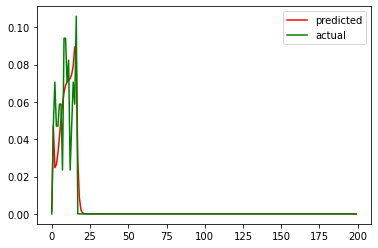

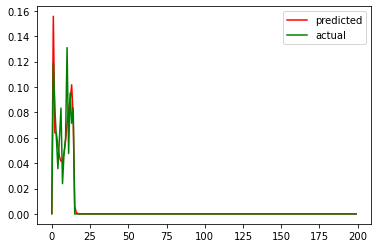

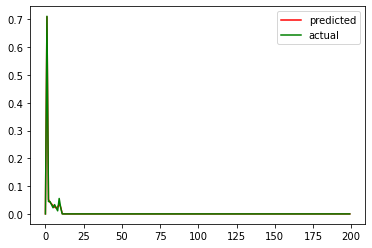

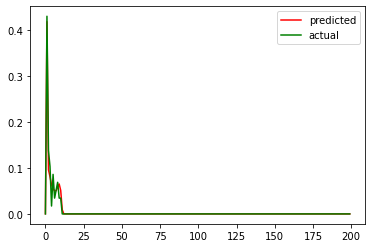

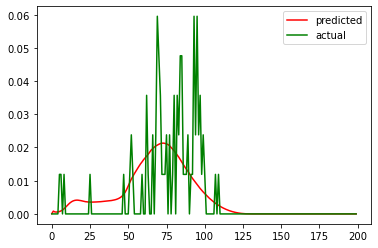

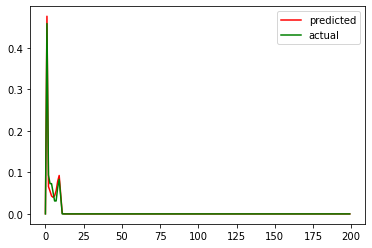

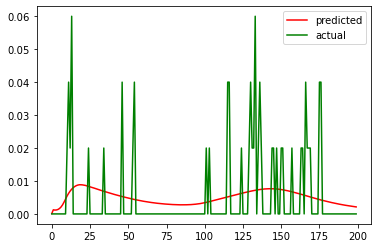

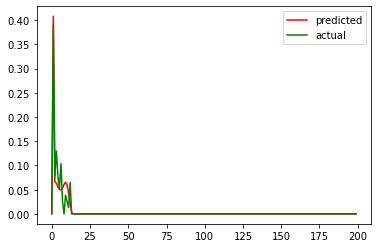

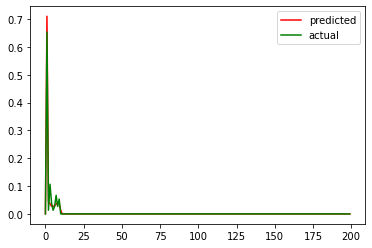

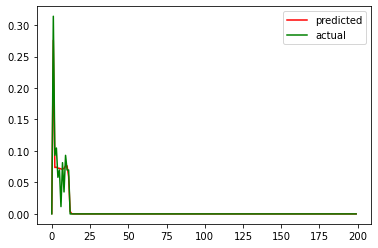

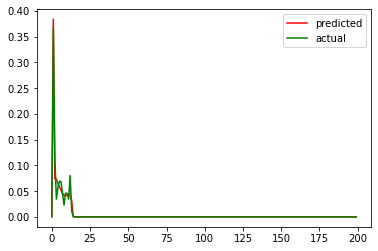

In [24]:
test_count = 0
while(test_count<=10):
    pos =  random.randint(0,1000)
    plt.plot(y_pred[pos], 'r',label = 'predicted')
    plt.plot(y_act[pos], 'g', label = 'actual')
    plt.legend()
    plt.show()
    test_count+=1